In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [19]:
# import
import numpy as np
import seaborn as sns # iris 데이터
import pandas as pd # 원핫인코딩
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자 -> 숫자)
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화


- iris 데이터
1. sepal_length : 꽃받침길이
2. sepal_width : 꽃받침넓이
3. petal_length : 꽃잎길이
4. peal_width : 꽃잎넓이
5. species : 종(setosa, verisicolor, virginica)

In [10]:
# 문자변수의 원핫인코딩 방법 1
iris = sns.load_dataset('iris')
# to_categorical(iris['species'])
labelEncoder = LabelEncoder()
# labelEncoder.fit(iris['species'])
# iris['y'] = labelEncoder.transform(iris['species'])
iris['y'] = labelEncoder.fit_transform(iris.species)
# iris.iloc[::25]
to_categorical(iris['y'])[::25] # to_categorical의 결과는 numpy배열

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [28]:
# 문자변수 원핫인코딩 방법 2
iris = sns.load_dataset('iris')
pd.get_dummies(iris.species).values # pd.get_dummies 결과는 데이터프레임
pd.get_dummies(iris.species).to_numpy()[::25]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [25]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() 결측치 있으면 결측치 처리
# iris['species'].value_counts() # 타겟변수의분포
# 독립변수와 타겟변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:,-1]
iris_Y = pd.get_dummies(iris_y).values
# iris_Y[::50]
# 훈련셋 : 테스트셋 = 8:2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                    train_size=0.8, # 훈련셋비율
#                                                    test_size=0.2, # 테스트 비율
                                                    stratify=iris_Y, # 층화추출
                                                    random_state=7 # 랜덤시드값
                                                   )
print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [26]:
# 층화추출이 되었는지 확인
# iris_Y.argmax(axis=1)
print(pd.Series(np.argmax(iris_Y, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_train, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_test, axis=1)).value_counts())

0    50
1    50
2    50
dtype: int64
0    40
2    40
1    40
dtype: int64
0    10
2    10
1    10
dtype: int64


In [23]:
pd.Series(np.argmax(Y_train, axis=1)).value_counts()

0    43
2    39
1    38
dtype: int64

In [38]:
# 2. 모델구성(입력4, 출력3)
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax')) # 출력층
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                320       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                6450      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 30)               

In [41]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# 4. 학습 : epoch마다 val_accuracy값이 좋아지고 있으면 model 자동 저장(콜백 추가)
    # 모델 자동 저장 경로 : ./model/iris-002-val0.8745.h5
import os
model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder) : # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델 자동 저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file,
                             monitor='val_accuracy', # 모니터링 지표(기본값 : val_loss)
                             mode='max',
                             save_best_only=True, # False : 매번 저장
                             verbose=1 # 모델 저장 시 로그 출력 (0: 로그 출력 X)
                            )
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor 기본값은 val_loss
hist = model.fit(X_train, Y_train,
                 #batch_size=40,
                 epochs=500,
                 validation_split=0.2, # 훈련셋의 20%를 검증셋으로
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0707 - accuracy: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./model_iris\iris-001-val0.3333.h5
3/3 [==============================] - 1s 112ms/step - loss: 1.0966 - accuracy: 0.3646 - val_loss: 1.0289 - val_accuracy: 0.3333
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.9864 - accuracy: 0.4688
Epoch 2: val_accuracy improved from 0.33333 to 0.70833, saving model to ./model_iris\iris-002-val0.7083.h5
3/3 [==============================] - 0s 28ms/step - loss: 1.0135 - accuracy: 0.4271 - val_loss: 0.9815 - val_accuracy: 0.7083
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0639 - accuracy: 0.4688
Epoch 3: val_accuracy did not improve from 0.70833
3/3 [==============================] - 0s 18ms/step - loss: 1.0514 - accuracy: 0.4583 - val_loss: 0.9477 - val_accuracy: 0.7083
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0022 

Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3315 - accuracy: 0.8750
Epoch 30: val_accuracy improved from 0.91667 to 0.95833, saving model to ./model_iris\iris-030-val0.9583.h5
3/3 [==============================] - 0s 31ms/step - loss: 0.3018 - accuracy: 0.8646 - val_loss: 0.2157 - val_accuracy: 0.9583
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4308 - accuracy: 0.8125
Epoch 31: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 16ms/step - loss: 0.3710 - accuracy: 0.8333 - val_loss: 0.2204 - val_accuracy: 0.9583
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2196 - accuracy: 0.9375
Epoch 32: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 16ms/step - loss: 0.2478 - accuracy: 0.9271 - val_loss: 0.2348 - val_accuracy: 0.8750
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2141 - accuracy: 0.9375
Epoch 33: val_accuracy did n

Epoch 60/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2696 - accuracy: 0.8750
Epoch 60: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 17ms/step - loss: 0.2321 - accuracy: 0.8958 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2786 - accuracy: 0.8750
Epoch 61: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 18ms/step - loss: 0.2074 - accuracy: 0.9167 - val_loss: 0.1576 - val_accuracy: 0.9583
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1244 - accuracy: 0.9688
Epoch 62: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.9479 - val_loss: 0.1627 - val_accuracy: 0.9583
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2796 - accuracy: 0.8750
Epoch 63: val_accuracy did not improve from 0.95833
3/3 [===========================

Epoch 90/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1866 - accuracy: 0.9375
Epoch 90: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 18ms/step - loss: 0.1307 - accuracy: 0.9479 - val_loss: 0.2768 - val_accuracy: 0.8750
Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1395 - accuracy: 0.9062
Epoch 91: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 17ms/step - loss: 0.0841 - accuracy: 0.9479 - val_loss: 0.2220 - val_accuracy: 0.9583
Epoch 92/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1088 - accuracy: 0.9688
Epoch 92: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 19ms/step - loss: 0.1339 - accuracy: 0.9583 - val_loss: 0.1858 - val_accuracy: 0.9583
Epoch 93/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1881 - accuracy: 0.9062
Epoch 93: val_accuracy did not improve from 0.95833
3/3 [===========================

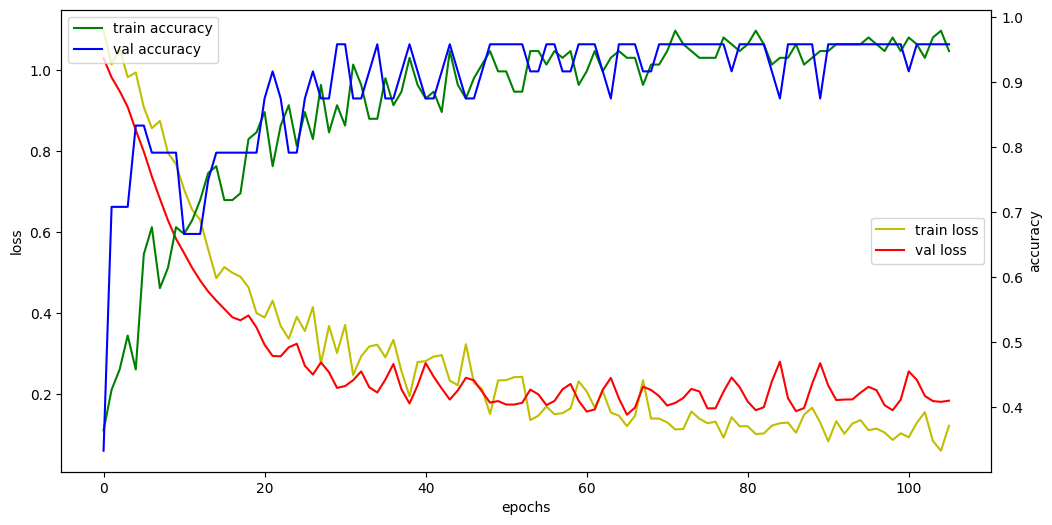

In [42]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [62]:
# 6. 모델 평가(evaluate : 테스트셋 / 교차, recall, precision : y실제값, y예측값)
# iris-030-val0.9583.h5 모델도 같이 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
# 학습된 모델
loss, acc = model.evaluate(X_test, Y_test,verbose=0)
loss, acc
# 모델의 recall과 precision을 위해 실제값과 예측값
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test,verbose=0), axis=1)
recall = recall_score(real, pred, average='weighted') # average = 'weighted' : 다중분류
precision = precision_score(real, pred, average='weighted')
f1        = f1_score(real, pred, average='weighted')
print("model accuracy : ",acc)
print("model recall : ", recall)
print("model precision : ", precision)
print("model f1 score : ", f1)
# 저장된 모델의 평가
model2  = load_model('model_iris/iris-030-val0.9583.h5')
loss, acc = model2.evaluate(X_test, Y_test,verbose=0)
pred = model2.predict(X_test,verbose=0).argmax(axis=1)
recall = recall_score(real, pred, average='weighted')
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print("mode2 accuracy : ",acc)
print("mode2 recall : ", recall)
print("mode2 precision : ", precision)
print("mode2 f1 score : ", f1)

model accuracy :  1.0
model recall :  1.0
model precision :  1.0
model f1 score :  1.0
1/1 [==============================] - 0s 134ms/step - loss: 0.1511 - accuracy: 1.0000
mode2 accuracy :  1.0
mode2 recall :  1.0
mode2 precision :  1.0
mode2 f1 score :  1.0


In [64]:
# 교차표
pred = np.argmax(model.predict(X_test,verbose=0), axis=1)
pd.crosstab(real, pred,
           rownames=['real'], colnames=['pred'])

pred,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,0,10


In [65]:
confusion_matrix(real, pred)

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]], dtype=int64)

In [68]:
# 모델 저장 및 사용
save_model(model, 'model/iris.h5')
model.save('model/iris.h5') # tensorflow 2.18 이상일 경우 확장자를 .keras로도 사용 가능

In [69]:
# 모델 예측
# iris.loc[100] (6.3, 3.3, 6.0, 2.5) 예측하기
result = model.predict([[6.3, 3.3, 6.1, 2.5]])
np.argmax(result) # virginica로 예측

1/1 [==============================] - 0s 37ms/step


2